# Network Science - MDS - UDD 2022
## Introducción a Ciencia de Redes


#### Cristian Candia-Castro Vallejos, Ph.D.$^{1,2}$

- [1] Data Science Institute (IDS), Universidad del Desarrollo,Chile
- [2] Northwestern Institute on Complex Systems, Kellogg School of Management, Northwestern Unviersity, USA


Referencias:
1. https://publish.illinois.edu/pynetworkshop/
2. https://github.com/MridulS/pydata-networkx



### Redes? Grafos?

Una estructura matemática utilizada para modelar relaciones por pares entre objetos, donde los objetos generalmente se denominan `nodos` y la relación entre ellos `enlaces`.

$G = (V, E)$

$V$ = conjunto de nodos/vértices

$E$ = conjunto de $(x, y)$ enlaces

In [1]:
# Si arroja el error random_state_index is incorrect, intentar:

# import decorator

In [2]:
# print(decorator.__version__)

In [3]:
# ! pip install decorator==5.0.9

In [4]:
# Luego reiniciar Jupyter y correr:

# ! pip install networkx

In [5]:
# Module 1: Comenzando con NetworkX

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import collections

import networkx as nx

%matplotlib inline

import urllib.request as urllib
import io

# path = 'https://saref.github.io/teaching/PyNetworkshop/'

# Cambiemos de tema y hablemos de Juego de tronos (Network of Thrones)

¿Es sorprendente verdad? ¿Cuál es la relación entre un programa de televisión / novela de fatansia y la ciencia de redes o Python?

Si no has oído hablar de Game of Thrones, entonces debes ser muy bueno para aislarte. Game of Thrones es la popular serie de televisión de HBO basada en la (también) popular serie de libros "A Song of Ice and Fire" de George R.R. Martin. 

Ahora, analizaremos la red de co-ocurrencia de los personajes en los libros de Juego de Tronos. Aquí, se considera que dos personajes coexisten si sus nombres aparecen en hasta a 15 palabras de distancia entre sí en los libros.

<!-- ![](img/got.png) -->

<img src="img/got.png" width="800" height="400">


In [80]:
#!conda install --yes --prefix {sys.prefix} community # 

# # !conda install --yes --prefix {sys.prefix} python-louvain # 

# !pip install python-louvain



In [81]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
# import community
from community import community_louvain
import numpy as np


%matplotlib inline

### Cargamos los datasets

In [82]:
book1 = pd.read_csv('data/asoiaf-book1-edges.csv')
book2 = pd.read_csv('data/asoiaf-book2-edges.csv')
book3 = pd.read_csv('data/asoiaf-book3-edges.csv')
book4 = pd.read_csv('data/asoiaf-book4-edges.csv')
book5 = pd.read_csv('data/asoiaf-book5-edges.csv')

El DataFrame resultante `book1` tiene 5 columnas: origen, destino, tipo, peso y libro. El origen y el destino son los dos nodos que están vinculados por un enlace. Una red puede tener enlaces dirigidos o no dirigidos y en esta red todos los enlaces no están dirigidos. El atributo de peso de cada enlace nos dice el número de interacciones que los personajes han tenido sobre el libro, y la columna del libro nos dice el número del libro.

In [83]:
# book1.head()
book1.sort_values('weight',ascending=False).head()

,Source,Target,Type,weight,book
329,Eddard-Stark,Robert-Baratheon,Undirected,291,1
134,Bran-Stark,Robb-Stark,Undirected,112,1
62,Arya-Stark,Sansa-Stark,Undirected,104,1
249,Daenerys-Targaryen,Drogo,Undirected,101,1
479,Joffrey-Baratheon,Sansa-Stark,Undirected,87,1


Una vez que tenemos los datos cargados como un DataFrame de pandas, es hora de crear una red. Creamos un grafo para cada libro. Es posible crear un MultiGraph en lugar de 5 grafos, pero es más fácil jugar con diferentes gráficos.

In [84]:
G_book1 = nx.Graph()
G_book2 = nx.Graph()
G_book3 = nx.Graph()
G_book4 = nx.Graph()
G_book5 = nx.Graph()

Completemos el grafo con los enlaces del DataFrame de pandas.

In [85]:
for row in book1.iterrows(): #Itera las filas de DataFrame como pares (index, series).
    G_book1.add_edge(row[1]['Source'], row[1]['Target'],weight=row[1]['weight'], book=row[1]['book'])

In [86]:
row

(683,
 Source       Waymar-Royce
 Target    Will-(prologue)
 Type           Undirected
 weight                 18
 book                    1
 Name: 683, dtype: object)

In [87]:
for row in book2.iterrows():
    G_book2.add_edge(row[1]['Source'], row[1]['Target'], weight=row[1]['weight'], book=row[1]['book'])
for row in book3.iterrows():
    G_book3.add_edge(row[1]['Source'], row[1]['Target'], weight=row[1]['weight'], book=row[1]['book'])
for row in book4.iterrows():
    G_book4.add_edge(row[1]['Source'], row[1]['Target'], weight=row[1]['weight'], book=row[1]['book'])
for row in book5.iterrows():
    G_book5.add_edge(row[1]['Source'], row[1]['Target'], weight=row[1]['weight'], book=row[1]['book'])

In [88]:
books = [G_book1, G_book2, G_book3, G_book4, G_book5]

Echemos un vistazo a estos enlaces

In [89]:
list(G_book1.edges(data=True))[16]#data=True muestra los atributos del enlace: peso y libro en este caso

('Jaime-Lannister', 'Loras-Tyrell', {'weight': 3, 'book': 1})

In [90]:
list(G_book1.edges(data=True))[400]

('Benjen-Stark', 'Theon-Greyjoy', {'weight': 4, 'book': 1})

In [91]:
len(list(G_book1.edges()))

684

### Encontrar el nodo/personaje más importante en estas redes.

¿Es Jon Snow, Tyrion, Daenerys o alguien más? ¡Vamos a ver! Network Science nos ofrece muchas métricas diferentes para medir la importancia de un nodo en una red como vimos en la primera parte del taller. 

**Tenga en cuenta que no existe una forma "correcta" de calcular el nodo más importante de una red, cada métrica tiene un significado diferente.**

Primero, midamos la importancia de un nodo en una red observando la cantidad de vecinos que tiene, es decir, la cantidad de nodos a los que está conectado. Por ejemplo, una cuenta influyente en Twitter, donde la relación seguidor-seguidor forma la red, es una cuenta que tiene un alto número de seguidores. Esta medida de importancia se llama centralidad de grado.

Usando esta medida, extraigamos los diez personajes más importantes del primer libro (libro [0]) y el quinto libro (libro [4]).

In [92]:
deg_cen_book1 = nx.degree_centrality(books[0])

In [93]:
deg_cen_book5 = nx.degree_centrality(books[4])

In [94]:
sorted(deg_cen_book1.items(), key=lambda x:x[1], reverse=True)[0:10]

[('Eddard-Stark', 0.3548387096774194),
 ('Robert-Baratheon', 0.2688172043010753),
 ('Tyrion-Lannister', 0.24731182795698928),
 ('Catelyn-Stark', 0.23118279569892475),
 ('Jon-Snow', 0.19892473118279572),
 ('Robb-Stark', 0.18817204301075272),
 ('Sansa-Stark', 0.18817204301075272),
 ('Bran-Stark', 0.17204301075268819),
 ('Cersei-Lannister', 0.16129032258064518),
 ('Joffrey-Baratheon', 0.16129032258064518)]

In [95]:
sorted(deg_cen_book5.items(), key=lambda x:x[1], reverse=True)[0:10]
#key recive la funcion para ordenar, lambda es la funcion "al vuelo" para ordenar

[('Jon-Snow', 0.1962025316455696),
 ('Daenerys-Targaryen', 0.18354430379746836),
 ('Stannis-Baratheon', 0.14873417721518986),
 ('Tyrion-Lannister', 0.10443037974683544),
 ('Theon-Greyjoy', 0.10443037974683544),
 ('Cersei-Lannister', 0.08860759493670886),
 ('Barristan-Selmy', 0.07911392405063292),
 ('Hizdahr-zo-Loraq', 0.06962025316455696),
 ('Asha-Greyjoy', 0.056962025316455694),
 ('Melisandre', 0.05379746835443038)]

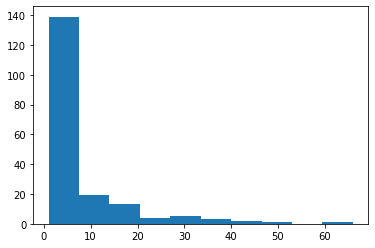

In [96]:
# Plot a histogram of degree centrality
plt.hist(list(dict(nx.degree(G_book1)).values()))
plt.show()

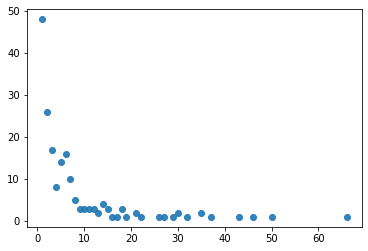

In [97]:
d= {}
for i, j in dict(nx.degree(G_book1)).items():
    if j in d:
        d[j] += 1
    else:
        d[j] = 1
x = list((d.keys()))
y = list(d.values())
plt.scatter(x, y, alpha=0.9)
plt.show()

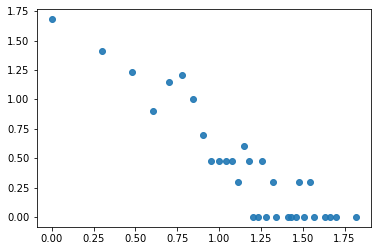

In [98]:
d = {}
for i, j in dict(nx.degree(G_book1)).items():
    if j in d:
        d[j] += 1
    else:
        d[j] = 1
x = np.log10(list((d.keys())))
y = np.log10(list(d.values()))
plt.scatter(x, y, alpha=0.9)
plt.show()

### Ejercicio 4

Cree una nueva medida de centralidad, `weighted_degree(Graph, weight)` que toma Graph y el atributo de peso y devuelve un diccionario de grados ponderados. El grado ponderado se calcula sumando el peso de todos los enlaces de un nodo. Luego, encuentre los cinco personajes más importantes de acuerdo con esta medida.

In [99]:
#Escriba su código acá (siempre pueden agregar más líneas de ser necesario):





In [100]:
# plt.hist(list(weighted_degree(G_book1, 'weight').values()))
# plt.show()

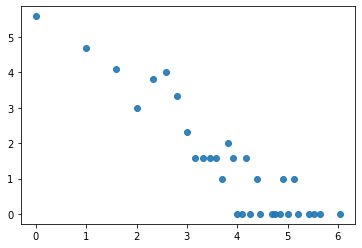

In [101]:
d = {}
for i, j in dict(nx.degree(G_book1)).items():
#     print(i,j)
    if j in d:
        d[j] += 1 #cuenta la cantidad de veces que el mismo grado "ocurre"
    else:
        d[j] = 1
x = np.log2(list((d.keys())))
y = np.log2(list(d.values()))
plt.scatter(x, y, alpha=0.9)
plt.show()

In [102]:
# sorted(weighted_degree(G_book1, 'weight').items(), key=lambda x:x[1], reverse=True)[0:10]

### Hagamos esto para la centralidad de Betweenness y verifiquemos si esto hace alguna diferencia

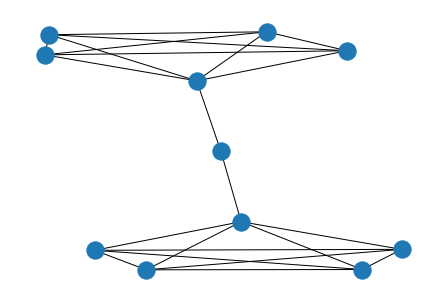

In [103]:
G = nx.barbell_graph(5, 1) #Recordemos: El nodo del centro es el de mayor betweennes
nx.draw(G)

In [104]:
# Primero verifique el grafo no ponderado, solo la estructura

sorted(nx.betweenness_centrality(G_book1).items(), key=lambda x:x[1], reverse=True)[0:10]

[('Eddard-Stark', 0.2696038913836117),
 ('Robert-Baratheon', 0.21403028397371796),
 ('Tyrion-Lannister', 0.1902124972697492),
 ('Jon-Snow', 0.17158135899829566),
 ('Catelyn-Stark', 0.1513952715347627),
 ('Daenerys-Targaryen', 0.08627015537511595),
 ('Robb-Stark', 0.07298399629664767),
 ('Drogo', 0.06481224290874964),
 ('Bran-Stark', 0.05579958811784442),
 ('Sansa-Stark', 0.03714483664326785)]

In [105]:
# Consideremos el peso ahora

sorted(nx.betweenness_centrality(G_book1, weight='weight').items(), key=lambda x:x[1], reverse=True)[0:10]

[('Robert-Baratheon', 0.23341885664466297),
 ('Eddard-Stark', 0.18703429235687297),
 ('Tyrion-Lannister', 0.15311225972516293),
 ('Robb-Stark', 0.1024018949825402),
 ('Catelyn-Stark', 0.10169012330302643),
 ('Jon-Snow', 0.09027684366394043),
 ('Jaime-Lannister', 0.07745109164464009),
 ('Rodrik-Cassel', 0.07667992877670296),
 ('Drogo', 0.06894355184677767),
 ('Jorah-Mormont', 0.0627085149665795)]

## PageRank
El algoritmo de billón de dólares, PageRank, funciona contando el número y la importancia de los enlaces a una página para determinar una estimación aproximada de la importancia del sitio web. La suposición subyacente es que es probable que los sitios web más importantes reciban más enlaces de otros sitios web.

<img src="img/pagerank.png" width="800" height="400">

<img src="img/pgr1.jpeg" width="800" height="400">


In [106]:
# por defecto, el atributo de peso en el pagerank es `weight`,
# por lo que usamos `peso = None` para encontrar los resultados no ponderados
sorted(nx.pagerank_numpy(G_book1, weight=None).items(), key=lambda x:x[1], reverse=True)[0:10]

C:\Users\pablo\AppData\Local\Temp\ipykernel_23116\111934550.py:3: DeprecationWarning: networkx.pagerank_numpy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.
  sorted(nx.pagerank_numpy(G_book1, weight=None).items(), key=lambda x:x[1], reverse=True)[0:10]
C:\Users\pablo\anaconda3\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:354: FutureWarning: google_matrix will return an np.ndarray instead of a np.matrix in
NetworkX version 3.0.
  M = google_matrix(


[('Eddard-Stark', 0.04552079222830664),
 ('Tyrion-Lannister', 0.03301362462493269),
 ('Catelyn-Stark', 0.03019310528663189),
 ('Robert-Baratheon', 0.029834742227736702),
 ('Jon-Snow', 0.026834499522066308),
 ('Robb-Stark', 0.02156294129724753),
 ('Sansa-Stark', 0.02000803404286463),
 ('Bran-Stark', 0.019945786786238352),
 ('Jaime-Lannister', 0.01750784720284688),
 ('Cersei-Lannister', 0.01708260458475806)]

In [107]:
sorted(nx.pagerank_numpy(G_book1, weight='weight').items(), key=lambda x:x[1], reverse=True)[0:10]

C:\Users\pablo\AppData\Local\Temp\ipykernel_23116\1358985202.py:1: DeprecationWarning: networkx.pagerank_numpy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.
  sorted(nx.pagerank_numpy(G_book1, weight='weight').items(), key=lambda x:x[1], reverse=True)[0:10]


[('Eddard-Stark', 0.0723940110049827),
 ('Robert-Baratheon', 0.04851727570509953),
 ('Jon-Snow', 0.04770689062474908),
 ('Tyrion-Lannister', 0.04367437892706293),
 ('Catelyn-Stark', 0.034667034701307435),
 ('Bran-Stark', 0.029774200539800184),
 ('Robb-Stark', 0.02921618364519686),
 ('Daenerys-Targaryen', 0.027089622513021105),
 ('Sansa-Stark', 0.02696177891568316),
 ('Cersei-Lannister', 0.021631679397418984)]

### ¿Existe una correlación entre estas métricas?

#### Ejercicio

Encuentre la correlación entre estas cuatro métricas de centralidad.

- PageRank
- betweenness_centrality
- weighted_degree
- centralidad de grado

In [108]:
cor = pd.DataFrame.from_records(
    [nx.pagerank_numpy(G_book1, weight='weight'),
     nx.betweenness_centrality(G_book1, weight='weight'),
#      weighted_degree(G_book1, 'weight'),
     nx.degree_centrality(G_book1)])

C:\Users\pablo\AppData\Local\Temp\ipykernel_23116\2590846740.py:2: DeprecationWarning: networkx.pagerank_numpy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.
  [nx.pagerank_numpy(G_book1, weight='weight'),


In [109]:
cor.T.corr()

,0,1,2
0,1.000000,0.870214,0.949307
1,0.870214,1.000000,0.871385
2,0.949307,0.871385,1.000000


## Evolución de la importancia de los personajes sobre los libros

Según la centralidad de grado, el personaje más importante del primer libro es Eddard Stark, pero ni siquiera está en el top 10 del quinto libro. La importancia cambia en el transcurso de cinco libros (hay muchas muertes :B)

Veamos la evolución de la centralidad de grado de un par de personajes como Eddard Stark, Jon Snow, Tyrion, que aparecieron en el top 10 de centralidad de grado en el primer libro.

Creamos un DataFrame con columnas de personajes y los libros como índices donde cada entrada es la centralidad de grado del personaje en ese libro en particular y trazamos la evolución de la centralidad de grado para Eddard Stark, Jon Snow y Tyrion.

Podemos ver que la importancia de Eddard Stark en la red diminuye y con Jon Snow hay una caída en el cuarto libro pero un aumento repentino en el quinto libro.

<AxesSubplot:>

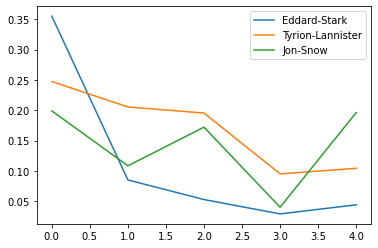

In [110]:
evol = [nx.degree_centrality(book) for book in books]#para cada red calcula el grado de nodo
evol_df = pd.DataFrame.from_records(evol).fillna(0)#Crea un objeto DataFrame a partir de un ndarray estructurado, una secuencia de tuplas o diccionarios, o un DataFrame.
evol_df[['Eddard-Stark', 'Tyrion-Lannister', 'Jon-Snow']].plot()

#Nota: Los corchetes interiores son para la lista y los corchetes externos son operadores de indexación, es decir, 
#debe usar corchetes dobles si seleccionas dos o más columnas. Con un nombre de columna, un solo par de corchetes 
#devuelve una Series, mientras que los corchetes dobles devuelven un dataframe.


In [111]:
evol_df['Eddard-Stark']#, 'Tyrion-Lannister', 'Jon-Snow']

0    0.354839
1    0.085271
2    0.052980
3    0.029304
4    0.044304
Name: Eddard-Stark, dtype: float64

In [112]:
set_of_char = set()
for i in range(5):
    set_of_char |= set(list(evol_df.T[i].sort_values(ascending=False)[0:5].index))# `|=` hace una unión de conjuntos
#     print(set_of_char)
set_of_char

{'Arya-Stark',
 'Brienne-of-Tarth',
 'Catelyn-Stark',
 'Cersei-Lannister',
 'Daenerys-Targaryen',
 'Eddard-Stark',
 'Jaime-Lannister',
 'Joffrey-Baratheon',
 'Jon-Snow',
 'Margaery-Tyrell',
 'Robb-Stark',
 'Robert-Baratheon',
 'Sansa-Stark',
 'Stannis-Baratheon',
 'Theon-Greyjoy',
 'Tyrion-Lannister'}

### Ejercicio 5 (resuelto)

Trace la evolución de la centralidad de grado ponderado de los personajes antes mencionados sobre los 5 libros y repita el mismo ejercicio para la centralidad de intermediación.

<AxesSubplot:>

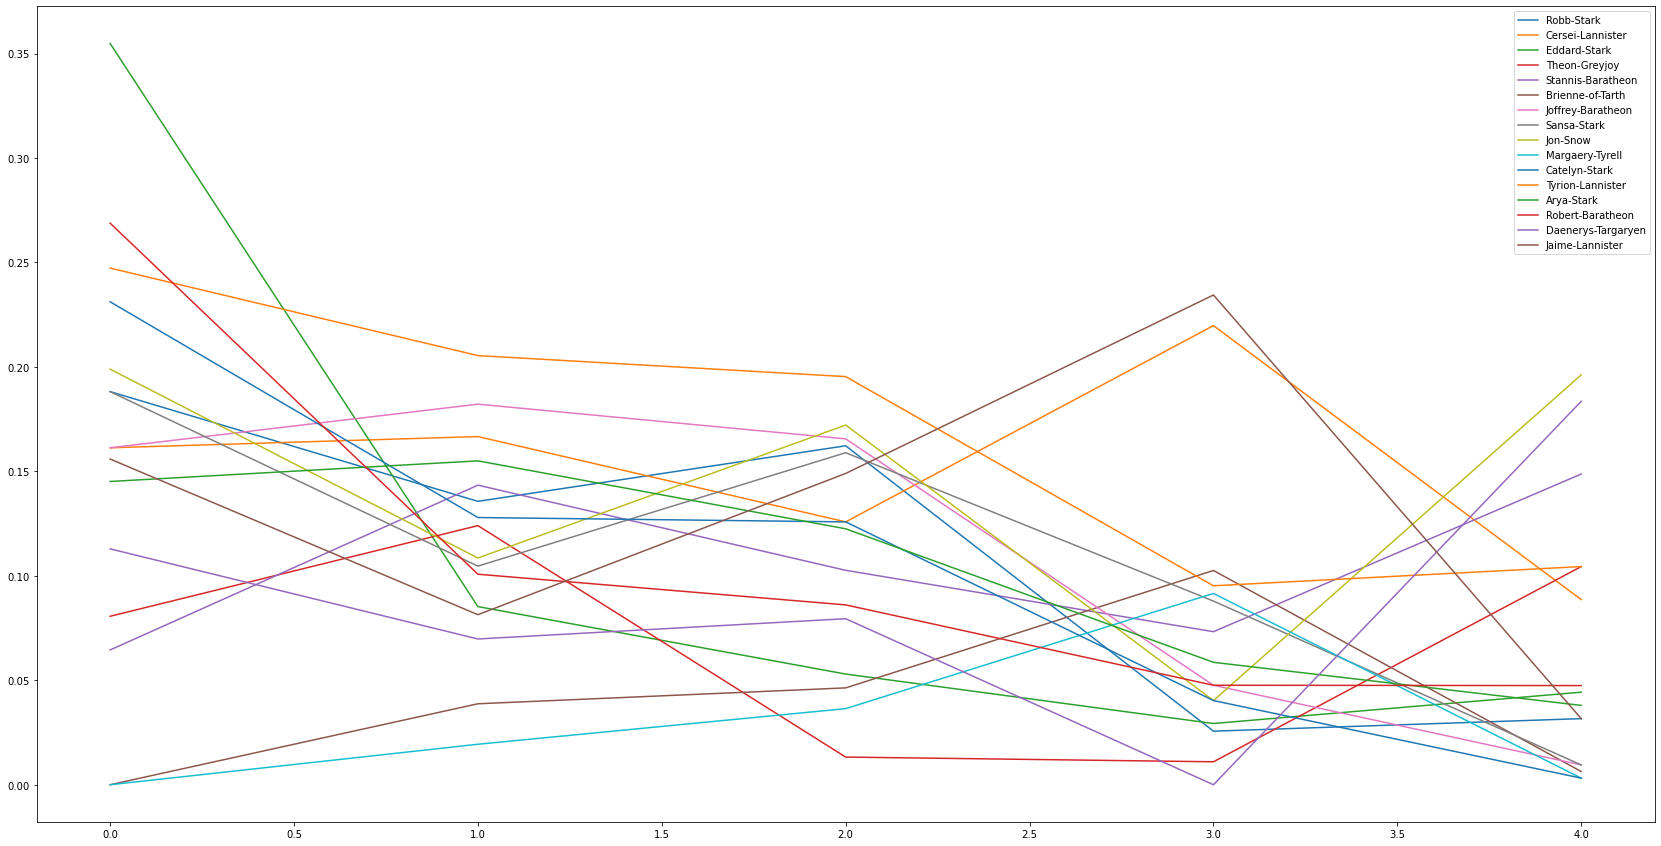

In [113]:
evol_df[list(set_of_char)].plot(figsize=(29,15))

<AxesSubplot:>

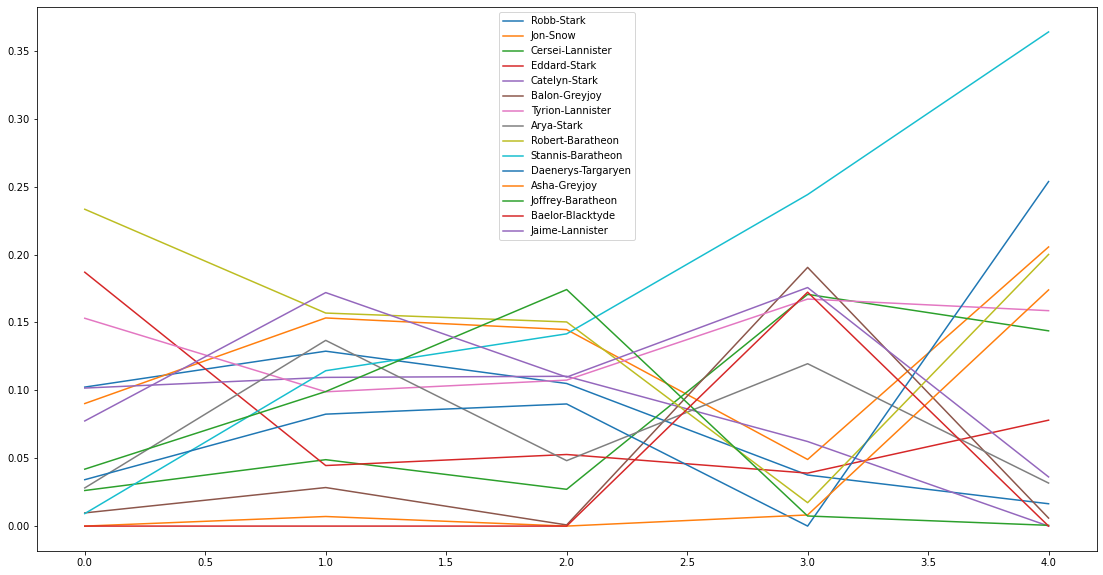

In [114]:
evol = [nx.betweenness_centrality(graph, weight='weight') for graph in [G_book1, G_book2, G_book3, G_book4, G_book5]]
evol_df = pd.DataFrame.from_records(evol).fillna(0)



set_of_char = set()
for i in range(5):
    set_of_char |= set(list(evol_df.T[i].sort_values(ascending=False)[0:5].index))


evol_df[list(set_of_char)].plot(figsize=(19,10))

### Entonces, ¿qué pasa con Stannis Baratheon?

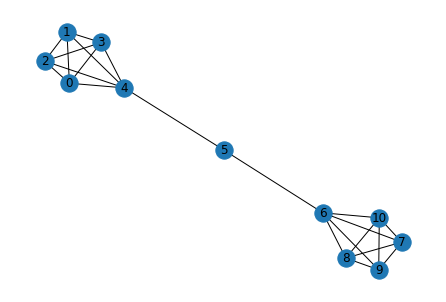

In [115]:
nx.draw(nx.barbell_graph(5, 1), with_labels=True)

In [116]:
sorted(nx.degree_centrality(G_book5).items(), key=lambda x:x[1], reverse=True)[:5]

[('Jon-Snow', 0.1962025316455696),
 ('Daenerys-Targaryen', 0.18354430379746836),
 ('Stannis-Baratheon', 0.14873417721518986),
 ('Tyrion-Lannister', 0.10443037974683544),
 ('Theon-Greyjoy', 0.10443037974683544)]

In [117]:
sorted(nx.betweenness_centrality(G_book5).items(), key=lambda x:x[1], reverse=True)[:5]

[('Stannis-Baratheon', 0.45283060689247934),
 ('Daenerys-Targaryen', 0.2959459062106149),
 ('Jon-Snow', 0.24484873673158666),
 ('Tyrion-Lannister', 0.20961613179551256),
 ('Robert-Baratheon', 0.17716906651536968)]

#### Detección de comunidad en redes
Se dice que una red tiene una estructura de comunidades si los nodos de la red se pueden agrupar fácilmente en conjuntos de nodos (potencialmente superpuestos) de modo que cada conjunto de nodos esté densamente conectado internamente (dentro de cada comunidad).

Usaremos el algoritmo de detección de la comunidad de Louvain para encontrar los módulos en nuestro grafo.

Se detectan 8 comunidades


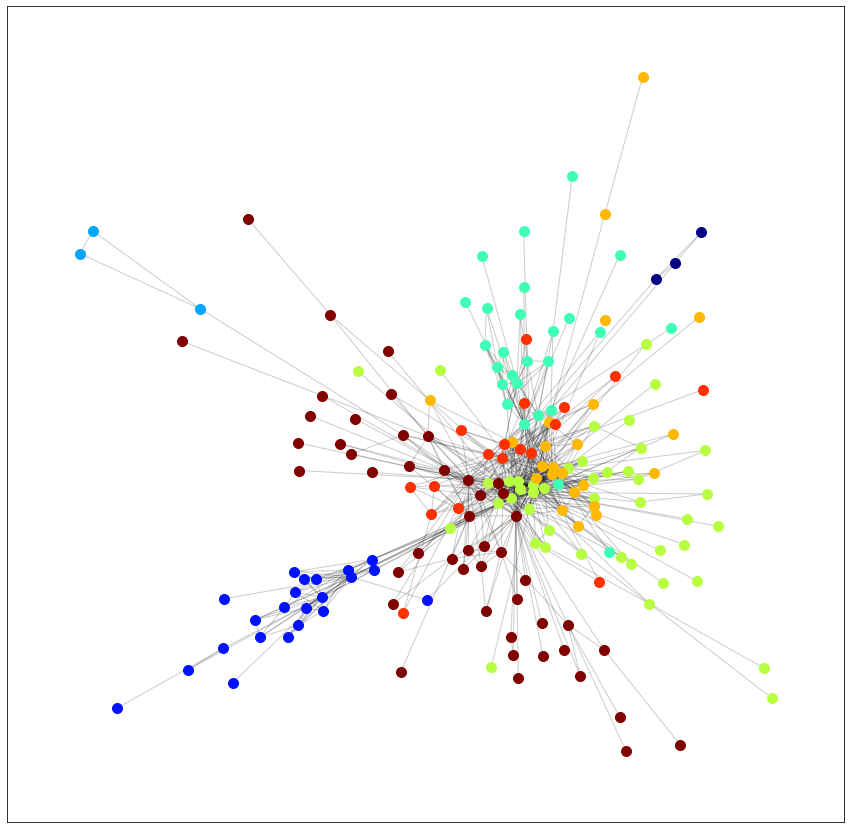

In [118]:
plt.figure(figsize=(15, 15))


# partition = community.best_partition(G_book1)
partition =community_louvain.best_partition(G_book1)

size = (len(set(partition.values())))#Numero de comunidades
print('Se detectan %d comunidades' % (size))

pos = nx.spring_layout(G_book1) # Layout para la red (coordenadas de los nodos y enlaces)

count = 0
colors = [np.array(cm.jet(x)).reshape(1,-1) for x in np.linspace(0, 1, size)]#cm.jet es el mapa de colores https://www.programcreek.com/python/example/56498/matplotlib.cm.jet
for com in set(partition.values()): #para cada comunidad
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]#guarda los personajes que pertenecen a la comunidad `com`
    nx.draw_networkx_nodes(G_book1, pos, list_nodes, node_size = 100, node_color=colors[count])#plotea nodos con colors por comunidad
    count = count + 1# para iterar sobre los colores
nx.draw_networkx_edges(G_book1, pos, alpha=0.2)#plotea enlaces
plt.show()



In [119]:
# Creamos un diccionario de personajes y sus respectivas comunidades
d = {}
for character, par in partition.items():
    if par in d:
        d[par].append(character)
    else:
        d[par] = [character]
d

{7: ['Addam-Marbrand',
  'Jaime-Lannister',
  'Tywin-Lannister',
  'Tyrion-Lannister',
  'Catelyn-Stark',
  'Rodrik-Cassel',
  'Bronn',
  'Chiggen',
  'Marillion',
  'Shae',
  'Shagga',
  'Vardis-Egen',
  'Willis-Wode',
  'Brynden-Tully',
  'Edmure-Tully',
  'Hoster-Tully',
  'Lysa-Arryn',
  'Nestor-Royce',
  'Walder-Frey',
  'Colemon',
  'Donnel-Waynwood',
  'Eon-Hunter',
  'Masha-Heddle',
  'Moreo-Tumitis',
  'Mya-Stone',
  'Mychel-Redfort',
  'Robert-Arryn',
  'Stevron-Frey',
  'Tytos-Blackwood',
  'Wendel-Manderly',
  'Chella',
  'Clement-Piper',
  'Karyl-Vance',
  'Conn',
  'Coratt',
  'Dolf',
  'Gunthor-son-of-Gurn',
  'Harys-Swyft',
  'Kevan-Lannister',
  'Jonos-Bracken',
  'Jyck',
  'Morrec',
  'Kurleket',
  'Leo-Lefford',
  'Lyn-Corbray',
  'Mord',
  'Timett',
  'Ulf-son-of-Umar'],
 1: ['Aegon-I-Targaryen',
  'Daenerys-Targaryen',
  'Aggo',
  'Drogo',
  'Jhogo',
  'Jorah-Mormont',
  'Quaro',
  'Rakharo',
  'Cohollo',
  'Haggo',
  'Qotho',
  'Doreah',
  'Eroeh',
  'Illyrio-Mopa

In [120]:
# la densidad de un grafo es una propiedad que determina la proporción de aristas que posee. 

nx.density(G_book1)

0.03933068828704502

In [121]:
nx.density(nx.subgraph(G_book1, d[4]))

0.11839323467230443

In [122]:
nx.density(nx.subgraph(G_book1, d[7]))

0.08599290780141844

In [123]:
nx.density(nx.subgraph(G_book1, d[7]))/nx.density(G_book1)

2.186407397038696

### Ejercicio 6

Encuentre el nodo más importante en las particiones según su centralidad de grado (esta es la normalizada).

## Un poco sobre la leyes de potencia en redes

<img src="img/plaw_random.png" width="800" height="400">


In [124]:
G_random = nx.erdos_renyi_graph(1000, 0.5)
# nx.draw(G_random)

In [125]:
G_ba = nx.barabasi_albert_graph(100, 2)# Genera garfos libre de escala

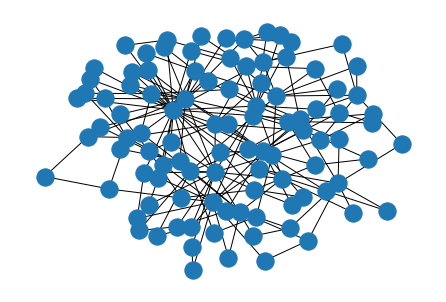

In [126]:
nx.draw(G_ba)

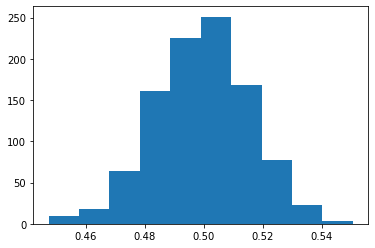

In [127]:
# Trazar un histograma de centralidad de grados
plt.hist(list(nx.degree_centrality(G_random).values()))
plt.show()

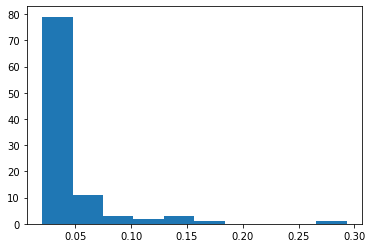

In [128]:
plt.hist(list(nx.degree_centrality(G_ba).values()))
plt.show()

In [129]:
# Generamos redes mas grandes

G_random = nx.erdos_renyi_graph(2000, 0.2)
G_ba = nx.barabasi_albert_graph(2000, 2)

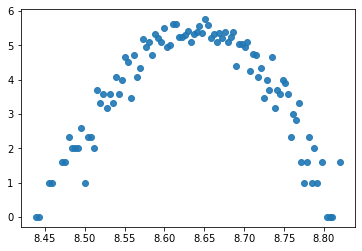

In [130]:
d = {}
for i, j in dict(nx.degree(G_random)).items():
    if j in d:
        d[j] += 1
    else:
        d[j] = 1
x = np.log2(list((d.keys())))
y = np.log2(list(d.values()))
plt.scatter(x, y, alpha=0.9)
plt.show()

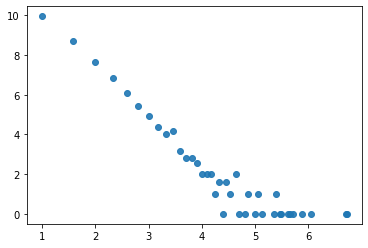

In [131]:
d = {}
for i, j in dict(nx.degree(G_ba)).items():
    if j in d:
        d[j] += 1
    else:
        d[j] = 1
x = np.log2(list((d.keys())))
y = np.log2(list(d.values()))
plt.scatter(x, y, alpha=0.9)
plt.show()

In [137]:
from sinfo import sinfo
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
community   0.16
matplotlib  3.5.1
networkx    2.8.8
numpy       1.21.5
pandas      1.4.2
sinfo       0.3.4
-----
IPython             8.2.0
jupyter_client      6.1.12
jupyter_core        4.9.2
jupyterlab          3.3.2
notebook            6.4.8
-----
Python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.22000-SP0
8 logical CPU cores, Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
-----
Session information updated at 2022-12-03 13:49
